# Postprocessing Demo
This notebook explains step by step how raw depth maps are refined and cleaned up.

### Setup

In [23]:
%load_ext autoreload
%autoreload 2

In [24]:
import os
import csv
import scipy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from mit_semseg.utils import colorEncode

from megadepth.postprocessing.image_processing import erode_and_remove, filter_unstable_depths
from megadepth.postprocessing.semantic_filtering import (
    apply_semantic_filtering,
    get_ordinal_labels,
    is_selfie_image,
)
from megadepth.postprocessing.semantic_segmentation import (
    get_segmentation_map,
    get_segmentation_model,
)
from megadepth.utils.io import load_depth_map

In [25]:
def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(10, 10))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])
 
    plt.show()

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    display(Image.fromarray(im_vis))

colors = scipy.io.loadmat('color150.mat')['colors']
names = {}
with open('object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

Feel free to change the variables in the following cell to try out other images and depth maps:

In [26]:
dense_model_dir = os.path.join("..", "data", "south-building", "dense", "colmap")
image_fn = "P1180218.JPG"

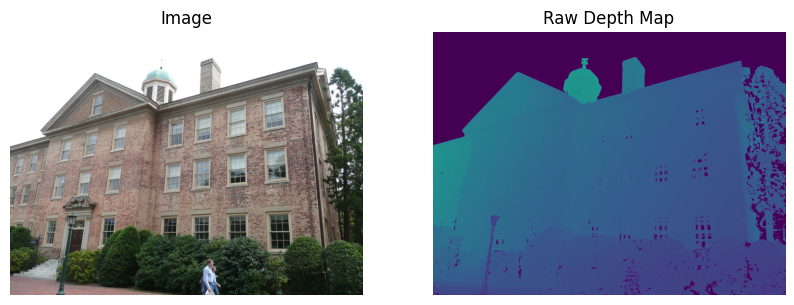

In [27]:
image = Image.open(os.path.join(dense_model_dir, "images", image_fn)).convert("RGB")
depth_map = load_depth_map(os.path.join(dense_model_dir, "stereo", "depth_maps", f"{image_fn}.geometric.bin"))

plot_images([image, depth_map], ["Image", "Raw Depth Map"])

### Semantic Segmentation

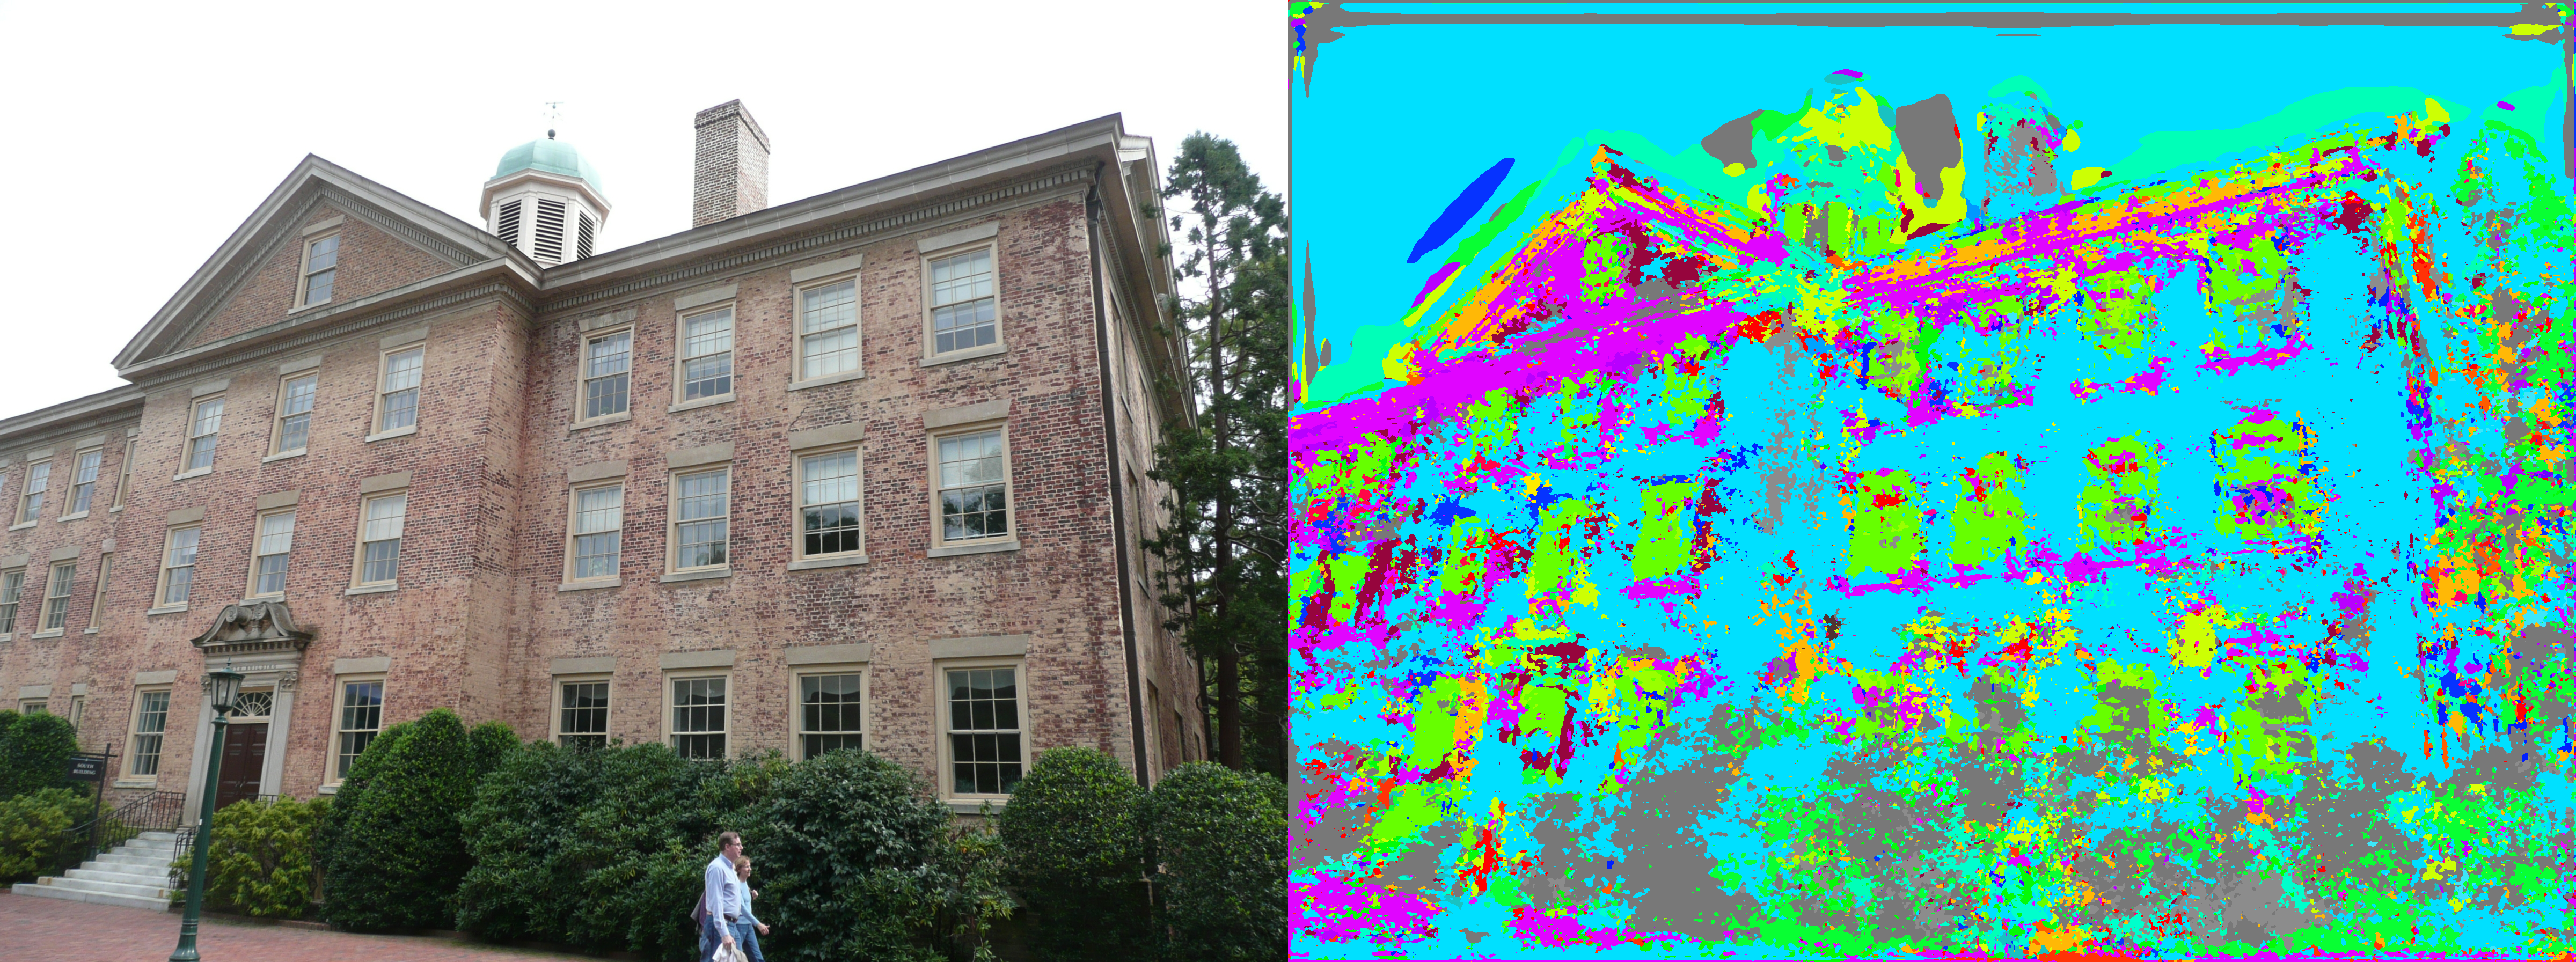

In [29]:
model = get_segmentation_model()
segmentation_map = get_segmentation_map(image, model)

visualize_result(np.array(image), segmentation_map)

In [31]:
segmentation_map.shape

(1793, 2400)

In [32]:
np.array(image).shape

(1793, 2400, 3)